### This notebook is derived from forkv1-of-ventilator-24oct-baseline-v7

### v7:
    
        * Result of 
            * CatBoost MAE Score, i = 400: 0.9797924232229948
            * CatBoost MAE Score, i = 4000: 0.7013653955979511
            * LGBM MAE Score, i = 0: 0.4675285363435313
            * Random Forest MAE Score: 0.4449081970704603
            * LB score: .5586 (rf) and .6421 (lgbm)
        * Run equation parameter investigation on laptop
        * R(1-e**-M*time/tot_time), where -M could be multiples of R and C
        * initial test with varying exponential values didn't produce much change.  Save
        * lots more trials on 10/26 to try and optimize the spring functions with no luck.
        * added lightgbm model, which gives lower scores than catboost, but submissions are whacked.
        * saving this version in a buggy state, but refactor on next iteration.
        
        * maybe delta from mean
        * derivative squared?
        * Need to ensure starting values are right...shift breath_id also...start with that

### v6:
    * add u_in exponential R(1-e**-1uin/max_uin.)
        * maybe use C as multiplier instead of R and experiment with e ratios
        * didn't get great improvement. Maybe relook at physics.
    * next, add log of u_in feature? Had issues with zeros.  

### v5:

   * Add RC feature (with spring above at .5): 1.0432, .780
   * Add R/C feature (with eqn above at .5): 1.027, .7752
   * Add C/R feature also (with eqn above at .5):  1.0276, .7743
   * added breath_id back: 1.0316, .77345
   * with second deriv = 1.013, .741  some improvement!  But why doesn't the corr reflect this?
   * catboost 10000 iterations: .677 !!! It is starting to increase better at higher iterations
   * 20000 iterations: .637 approaching the RF score (.61)
   * 30000 iterations! depth=6, .5887!!  But leaderboard was .70!  
       * **I guess that means overfitting!
   * with 3rd deriv and u_in_squared added: 1.0117, .7363, try rf: .50277 vs. .5846 lb...best so far
     * baselining for v5

### Previous Versions

Adding max u_in feature helped score from  ~.75 to ~.65.

Pipeline is:
* reduce memory
* split into two sets
* add features: max_time, max_u_in, dt, u_in_slope, u_in_area

Fork v1 adds u_in_ratio feature
* catboost drops a little 1.09 to ~1.065 ,didnt run rf.

Add 1/area feature since R decreases with increasing lung volume
   * helps a little, not much
   * with 1/R*area: 1.0727, .808181 
 
v4?
Add R(1-np.exp(-1*t/t_max)
   * spring R(1-np.exp(-1*time/time_max)): 1.0661, .7899
   * spring R(1-np.exp(-2*time/time_max)): 1.0612, .7857
   * spring R(1-np.exp(-3*time/time_max)): 1.0551, .7868
   * spring R(1-np.exp(-5*time/time_max)): 1.0575, .7847
   * spring R(1-np.exp(-R*time/time_max)): 1.0529, .7877
   * spring R(1-np.exp(-.5*R*time/time_max)): 1.0541, .7842
   * spring R(1-np.exp(-.2*R*time/time_max)): 1.0549, .7854


# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import platform
pd.options.mode.chained_assignment = None

# Functions

# Load Files

In [2]:
%%time
# Load files
if platform.system() == 'Windows' and platform.release() == '7':
    drive = 'F'
elif platform.system() == 'Windows' and platform.release() == '10':
    drive = 'C'
    
train = pd.read_csv(drive + r':\Sync\Work\Kaggle Competitions\Ventilator Pressure Prediction\Data\train.csv',nrows=80*10000)
test = pd.read_csv(drive + r':\Sync\Work\Kaggle Competitions\Ventilator Pressure Prediction\Data\test.csv')
    
#train = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
#test = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')

#sample data
y = train['pressure']


Wall time: 2.2 s


# Memory Reduction

In [3]:
# down convert columns to save memory...
def reduce_memory(df):
    
    print(f'Initial memory usage: {df.memory_usage().sum()/1024**2:0.1f}MB')
    df['id'] = df['id'].astype(np.int32)
    df['breath_id'] = df['breath_id'].astype(np.int32)
    df['R'] = df['R'].astype(np.int8)  #or OHC?
    df['C'] = df['C'].astype(np.int8)
    df['u_out'] = df['u_out'].astype(np.int8)
    df['u_in'] = df['u_in'].astype(np.float32)
    df['time_step'] = df['time_step'].astype(np.float32)
    print(f'New memory usage: {df.memory_usage().sum()/1024**2:0.1f}MB')
    
    # somewhere else I printed out a reduction as well.
    
#     for col in test.columns:
#         print(test[col].dtype)

In [4]:
print('Train:')
reduce_memory(train)
print('Test:')
reduce_memory(test)


Train:
Initial memory usage: 48.8MB
New memory usage: 20.6MB
Test:
Initial memory usage: 214.9MB
New memory usage: 72.9MB


# Split data into inhalitory and exhalitory phase (only scored on inhale)

In [107]:
train_in = train[train.u_out == 0]
test_in = test[test.u_out == 0]
y_in = train_in['pressure']

train_out = train[train.u_out == 1]
test_out = test[test.u_out == 1]

### Get indicies of valid breaths, and indicies of transition

In [108]:
#check for infinite or nan values

#train_in.inv_area.isinf().sum()
#np.isinf(train_in).values.sum()

#  Add Features

    1. Apply lag shift (tested shift =1 ) 
        Shift = 2 performs better (2.37 vs. 2.0x)
    2. Add differentials for dt and du_in
    3. Add integral column for d_uin



### Apply lag shift, Add Differential, Integral, and other Features

In [109]:
# def apply_features(df,ushift):
    
#     # apply lag shift
#     shift = ushift
#     u_in_lag = df.u_in.shift(shift,fill_value=0)
#     df.loc[:,'u_in_lag'] = u_in_lag.copy()

#     # max/min features
#     df["max_u_in"] = df.groupby("breath_id")["u_in"].transform("max")
#     df["max_time"] = df.groupby("breath_id")["time_step"].transform("max")
    
#     # ratios
#     df["u_in_ratio"] = df.u_in/df.max_u_in
#     df["u_in_ratio"] = df.u_in_ratio.fillna(0)
#     df['RC'] = df.R * df.C
#     df['RoverC'] = df.R/df.C
#     df['CoverR'] = df.C/df.R
    
#     # dt
#     df['dt'] = df['time_step'].diff()
#     df['dt'].fillna(0, inplace=True)  # no na values so not needed
#     df['dt'].mask(df['dt'] < 0,0,inplace=True) #df.groupby('breath_id')['dt'].mean(), inplace=True)  #makes
    
#     # derivatives   
#     df['du_in'] = df['u_in_lag'].diff()  # then look where time delta is 0 and make this 0 also
#     df['du_in'].mask(df['dt'] == 0, 0, inplace=True)
#     #df['dt'].fillna(0, inplace=True)
#     df['du2_in'] = df['du_in'].diff()
#     df['du2_in'].mask(df['dt'] == 0, 0, inplace=True)
#     df['du3_in'] = df['du2_in'].diff()
#     df['du3_in'].mask(df['dt'] == 0, 0, inplace=True)

#     # integration
#     df['d_area'] = np.sqrt(df['dt'] * df['u_in_lag'])
#     df['u_in_area'] = df.groupby('breath_id')['d_area'].cumsum()#.shift(1,fill_value=0)
#     df['inv_area'] = train_in.C/df['u_in_area']
#     df.replace([np.inf, -np.inf], np.nan, inplace=True)
#     df['inv_area'].fillna(0, inplace=True)
#     df['u_in_sq'] = df.u_in_lag * df.u_in_lag
#     df['u_in_cube'] = df.u_in_lag**3/1000
#     df['u_in_ts'] = df.u_in_lag*df.time_step

#     # formulas
#     df['R_spring'] = df.R*(1-np.exp((-.32*df.R*df.time_step)/(df.max_time)))
#     df['U_spring'] = df.C*(1-np.exp((-.08*df.C*df.u_in_lag)/(df.max_u_in)))
#     df.replace([np.inf, -np.inf], np.nan, inplace=True)
#     df['R_spring'].fillna(0, inplace=True)
#     df['U_spring'].fillna(0, inplace=True)

#     # Drop unused axes
#     #df.drop(['d_area'],axis=1,inplace=True)
#     df.drop(['u_in'],axis=1,inplace=True)


In [110]:
# older version - is this the culprit?
def apply_features(df,ushift):
    
    # apply lag shift
    shift = ushift
    u_in_lag = df.u_in.shift(shift,fill_value=0)
    df.loc[:,'u_in_lag'] = u_in_lag.copy()

    # max/min/mean features
    df["max_u_in"] = df.groupby("breath_id")["u_in"].transform("max")
    df["max_time"] = df.groupby("breath_id")["time_step"].transform("max")
    df['mean_u_in'] = df.groupby("breath_id")["u_in"].transform("mean")
    
    # ratios
    df["u_in_ratio"] = df.u_in/df.max_u_in
    df["u_in_ratio"] = df.u_in_ratio.fillna(0)
    df['RC'] = df.R * df.C
    df['RoverC'] = df.R/df.C
    df['CoverR'] = df.C/df.R
    
    # dt
    df['dt'] = df['time_step'].diff()
    df['dt'].fillna(0, inplace=True)  # no na values so not needed
    df['dt'].mask(df['dt'] < 0,0,inplace=True) #df.groupby('breath_id')['dt'].mean(), inplace=True)  #makes
    
    # derivatives   
    df['du_in'] = df['u_in_lag'].diff()  # then look where time delta is 0 and make this 0 also
    df['du_in'].mask(df['dt'] == 0, 0, inplace=True)
    #df['dt'].fillna(0, inplace=True)
    df['du2_in'] = df['du_in'].diff()
    df['du2_in'].mask(df['dt'] == 0, 0, inplace=True)
    df['du3_in'] = df['du2_in'].diff()
    df['du3_in'].mask(df['dt'] == 0, 0, inplace=True)
    df['log_u_in'] = df['u_in_lag'].map(lambda i: np.log(i) if i > 0 else 0)

    # integration
    df['d_area'] = df['dt'] * df['u_in_lag']
    df['u_in_area'] = df.groupby('breath_id')['d_area'].cumsum()#.shift(1,fill_value=0)
    df['inv_area'] = 1/(df.C*df['u_in_area'])
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df['inv_area'].fillna(0, inplace=True)
    df['u_in_sq'] = df.u_in_lag * df.u_in_lag
    df['u_in_cube'] = df.u_in_lag**3/1000
    df['u_in_ts'] = df.u_in_lag*df.time_step
    
    # formulas
    df['R_spring'] = df.R*(1-np.exp((-.5*df.R*df.time_step)/df.max_time))
    df['U_spring'] = df.C*(1-np.exp((-.05*df.C*df.u_in_lag)/df.max_u_in))
    df['R_spring'].fillna(0, inplace=True)
    df['U_spring'].fillna(0, inplace=True)

    # Drop unused axes
    df.drop(['d_area'],axis=1,inplace=True)
    df.drop(['u_in'],axis=1,inplace=True)


In [111]:
apply_features(train_in,1)
apply_features(test_in,1)

In [112]:
np.isinf(train_in).values.sum()
train_in.isna().sum()

id            0
breath_id     0
R             0
C             0
time_step     0
u_out         0
pressure      0
u_in_lag      0
max_u_in      0
max_time      0
mean_u_in     0
u_in_ratio    0
RC            0
RoverC        0
CoverR        0
dt            0
du_in         0
du2_in        0
du3_in        0
log_u_in      0
u_in_area     0
inv_area      0
u_in_sq       0
u_in_cube     0
u_in_ts       0
R_spring      0
U_spring      0
dtype: int64

In [113]:
# this doesn't seem to be useful in selecting features.
#plt.figure(figsize=(17,15))
#sns.heatmap(train_in.corr(),annot=True)
#plt.savefig('heatmap',dpi=300)
np.abs(train_in.corrwith(y_in)).sort_values(ascending=False)

pressure      1.000000
u_in_area     0.582699
max_u_in      0.480606
time_step     0.421155
u_in_ts       0.393051
mean_u_in     0.358833
log_u_in      0.237758
u_in_lag      0.233817
dt            0.210131
u_in_ratio    0.204533
du_in         0.177298
u_in_sq       0.168797
R_spring      0.153793
du2_in        0.137766
u_in_cube     0.126819
CoverR        0.124600
C             0.095665
du3_in        0.077374
U_spring      0.054347
R             0.051295
max_time      0.050382
RoverC        0.035814
RC            0.033545
inv_area      0.005415
breath_id     0.003186
id            0.003172
u_out              NaN
dtype: float64

In [114]:
#test_in.u_out.isna().sum()

Visualize features

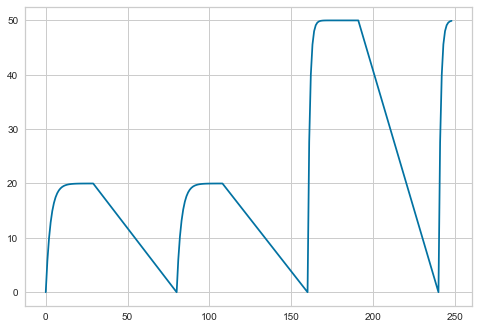

In [115]:

plt.plot(train_in.R_spring[0:100])


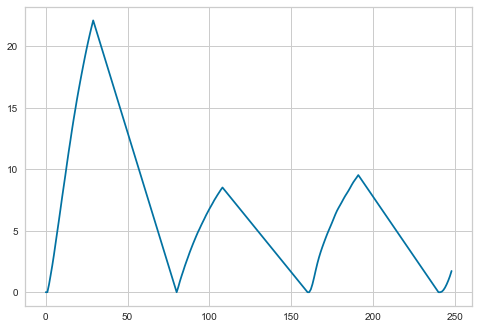

In [116]:
plt.plot(train_in.u_in_area[0:100])

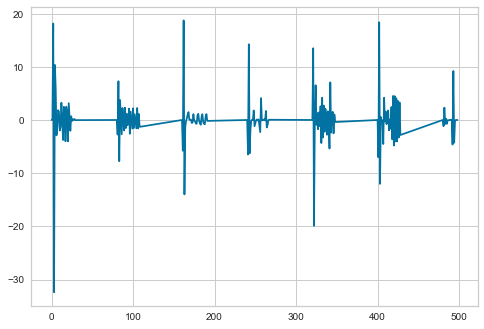

In [117]:
plt.plot(train_in.du3_in[0:200])

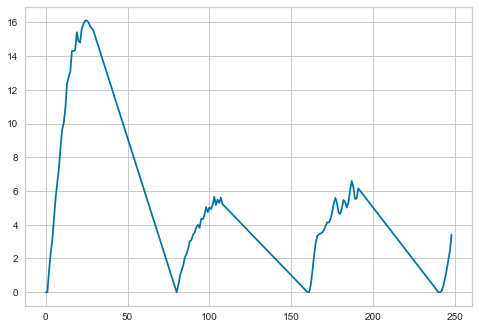

In [118]:
plt.plot(train_in.u_in_ts[0:100])

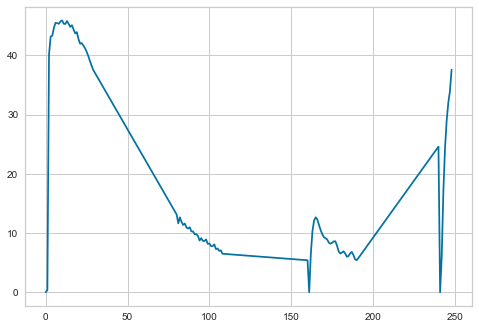

In [119]:
plt.plot(train_in.U_spring[0:100])

In [120]:
train_in.drop(columns = ['pressure'], inplace = True)

In [121]:
from sklearn.preprocessing import StandardScaler  #OrdinalEncoder,MinMaxScaler,
scaler = StandardScaler()
train_in = scaler.fit_transform(train_in)
test_in= scaler.transform(test_in)

# Model

In [122]:
from sklearn.metrics import mean_absolute_error  #confusion_matrix, classification_report

## Need to ditch split and go to cross validation

In [123]:
# Split data - after all analysis is done
from sklearn.model_selection import train_test_split

train_in.drop(columns = ['id','u_out'], inplace = True)
#test = test.drop(columns = 'id', inplace = True)

X_train, X_valid, y_train, y_valid = train_test_split(train_in, y_in, train_size=0.8, test_size=0.2,
                                                      random_state=12)
X_test_in = test_in.drop(columns=['id','u_out'],inplace=False)

AttributeError: 'numpy.ndarray' object has no attribute 'drop'

In [ ]:
train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7).split(df, groups=df['Group_Id']))

X_train = df.iloc[train_inds]
X_test = df.iloc[test_inds]


In [59]:
X_test_in

,breath_id,R,C,time_step,u_in_lag,max_u_in,max_time,mean_u_in,u_in_ratio,RC,...,du2_in,du3_in,log_u_in,u_in_area,inv_area,u_in_sq,u_in_cube,u_in_ts,R_spring,U_spring
0,0,5,20,0.000000,0.000000,37.542217,0.957189,19.702023,0.000000,100,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,5,20,0.031904,0.000000,37.542217,0.957189,19.702023,0.200176,100,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.399747,0.000000
2,0,5,20,0.063827,7.515046,37.542217,0.957189,19.702023,0.390272,100,...,7.515046,7.515046,2.016907,0.239907,0.208414,56.475910,0.424419,0.479665,0.767754,3.628264
3,0,5,20,0.095751,14.651675,37.542217,0.957189,19.702023,0.565513,100,...,-0.378416,-7.893462,2.684555,0.707644,0.070657,214.671585,3.145298,1.402913,1.106323,6.462545
4,0,5,20,0.127644,21.230610,37.542217,0.957189,19.702023,0.701103,100,...,-0.557695,-0.179279,3.055444,1.384742,0.036108,450.738800,9.569460,2.709951,1.417515,8.638626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4023945,125748,20,10,0.842145,0.000000,35.151390,0.976815,2.298701,0.000000,-56,...,0.000000,0.000000,0.000000,2.319345,0.043116,0.000000,0.000000,0.000000,19.996396,0.000000
4023946,125748,20,10,0.875648,0.000000,35.151390,0.976815,2.298701,0.000000,-56,...,0.000000,0.000000,0.000000,2.319345,0.043116,0.000000,0.000000,0.000000,19.997442,0.000000
4023947,125748,20,10,0.909185,0.000000,35.151390,0.976815,2.298701,0.003453,-56,...,0.000000,0.000000,0.000000,2.319345,0.043116,0.000000,0.000000,0.000000,19.998185,0.000000
4023948,125748,20,10,0.943148,0.121375,35.151390,0.976815,2.298701,0.000000,-56,...,0.121375,0.121375,-2.108874,2.323468,0.043039,0.014732,0.000002,0.114474,19.998718,0.017250


In [27]:
# cross validation
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score

model_cat = CatBoostRegressor(loss_function="MAE",
                               eval_metric="MAE",
                               task_type="GPU",
                               learning_rate=.25,
                               iterations=4000,
                               l2_leaf_reg=60,
                               random_seed=12,
                               #od_type="Iter",
                               depth=8,
                               #early_stopping_rounds=6500,
                               #border_count=64,
                               verbose=False
                              )

scores_cbcv = cross_val_score(model_cat, X_train, y_train, cv=3, scoring='neg_median_absolute_error')
print(f'Catboost CV scores: {scores_cbcv}')
print(f'Catboost CV mean: {scores_cbcv.mean()}')

#400 literations, .25,60,8
#Catboost CV scores: [-0.52191966 -0.52389751 -0.52226288]
#Catboost CV mean: -0.5226933519733302
# 4000 iterations: 
#Catboost CV scores: [-0.38611291 -0.3807639  -0.38101612]
#Catboost CV mean: -0.3826309765303269
#I dont really understnd this.  Not using cv, mae = ...
# iterations=400:  0.8206063709193067
# iterations=4000: 0.5566809151075147   ...this is with reduced data set

Catboost CV scores: [-0.38611291 -0.3807639  -0.38101612]
Catboost CV mean: -0.3826309765303269


In [24]:
print(f'Catboost CV scores: {scores_cbcv}')
print(f'Catboost CV mean: {scores_cbcv.mean()}')

# from sklearn.model_selection import cross_val_score

# cbc = CatBoostClassifier(max_depth=3)
# cvs = cross_val_score(cbc, X, y, cv=5, scoring='accuracy')
# print (f 'The mean value of cross val score is {cvs.mean()}')

Catboost CV scores: [-0.52191966 -0.52389751 -0.52226288]
Catboost CV mean: -0.5226933519733302


In [ ]:
#test_in["u_in_ratio"] = test_in.u_in_ratio.fillna(0)
test_in.isna().sum()

In [60]:
%%time
from catboost import CatBoostRegressor
# loop for manual hyper-parameter tuning
#for i in range(70,100,10):

model_cat = CatBoostRegressor(loss_function="MAE",
                           eval_metric="MAE",
                           task_type="GPU",
                           learning_rate=.25,
                           iterations=30000,
                           l2_leaf_reg=60,
                           random_seed=12,
                           #od_type="Iter",
                           depth=8,
                           #early_stopping_rounds=6500,
                           #border_count=64,
                           verbose=False
                          )
model_cat.fit(X_train,y_train)
pred_cat = model_cat.predict(X_valid)
score_cat = mean_absolute_error(y_valid,pred_cat)
#print(f'iters={i}, lr={j}, CatBoost MAE Score: {score_cat}')
print(f'CatBoost MAE Score, l2leafreg = {i}: {score_cat}')

# squared d_area (coor .17), 1.112, .8163.  This made things quite a bit worse...should be able to make better too!
# sqrt(d_area) (corr better .26): .726 (best so far), try rf I guess
# fixed u_in_ratio: get .9898, .7266 which is about the best so far, maybe try rf also 
# now .982, .7299
# add u_in_mean: best so far!  Check others: 
# CatBoost MAE Score, i = 400: 0.9797924232229948
# CatBoost MAE Score, i = 4000: 0.7013653955979511
# 24000, 30000: 
# CatBoost MAE Score, i = 24000: 0.5682470168611197
# CatBoost MAE Score, i = 30000: 0.5556862188534233
# set iterations to 30000, and vary depth
# CatBoost MAE Score, i = 3: 0.685390995463435
# CatBoost MAE Score, i = 4: 0.6050742278308203
# CatBoost MAE Score, i = 5: 0.5559855205707835
# CatBoost MAE Score, i = 6: 0.5246105311618575
# CatBoost MAE Score, i = 7: 0.5080718197763687
# CatBoost MAE Score, i = 8: 0.49928271392505474
# CatBoost MAE Score, i = 9: 0.516987320740242
# 8 looks like the best depth.  at 30000,8, vary learn rate
# CatBoost MAE Score, i = 0.01: 0.6498819475321668
# CatBoost MAE Score, i = 0.05: 0.5152475207161409
# CatBoost MAE Score, i = 0.1: 0.47572122198720496
# CatBoost MAE Score, i = 0.15: 0.4611122799735114
# CatBoost MAE Score, i = 0.2: 0.45492635320889013
# CatBoost MAE Score, i = 0.25: 0.45403070636220405
# CatBoost MAE Score, i = 0.3: 0.45729824531293445
# CatBoost MAE Score, i = 0.35: 0.4594907300273575
# CatBoost MAE Score, i = 0.4: 0.468537754427922
# CatBoost MAE Score, i = 0.45: 0.4741410550440582
# checkpoint, plot this, continue 
# 30000, 8, .25,  vary leaf_reg
# CatBoost MAE Score, l2leafreg = 10: 0.4586096233335787
# CatBoost MAE Score, l2leafreg = 20: 0.45747895689123014
# CatBoost MAE Score, l2leafreg = 30: 0.4550317585462768
# CatBoost MAE Score, l2leafreg = 40: 0.45503666180538077
# CatBoost MAE Score, l2leafreg = 50: 0.4550218737494876
# CatBoost MAE Score, l2leafreg = 60: 0.4544535398076451 - submit this last one and see how it looks .6046 lb :(

# with 10000 (sampled) breaths, 
# CatBoost MAE Score, iterations=400:   0.8206063709193067
# CatBoost MAE Score, iterations=4000:  0.5566809151075147
# CatBoost MAE Score, iterations=30000: 0.4824402629695751   ...this is vs. .455 with all data
# CatBoost MAE Score, iterations=40000: 0.4777799409793641



IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



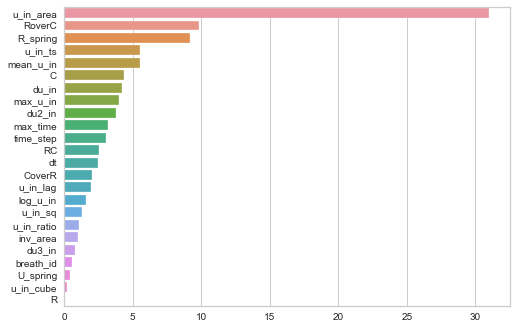

In [70]:
model_cat.feature_importances_
indices = np.argsort(model_cat.feature_importances_)[::-1]
g = sns.barplot(y=X_train.columns[indices],x = model_cat.feature_importances_[indices] , orient='h')

In [31]:
%%time
from lightgbm import LGBMRegressor


model_lgbm = LGBMRegressor(objective='regression_l1',n_jobs=-1,n_estimators=30000,learning_rate=0.2)
model_lgbm.fit(X_train,y_train)
pred_lgbm = model_lgbm.predict(X_valid)
score_lgbm = mean_absolute_error(y_valid,pred_lgbm)
print(f'LGBM MAE Score, i = {0}: {score_lgbm}')

#4000 iters: .642
#20000 iters: .570197, try submitting
#20000 after fixing bug, .55596
# again, .55093, .67xx on lb :(
# with u_in mean feature:  .467!  Try rf, maybe try submitting this too.  rf got lb .55xx, this is .64xx, saving anyways
#.467 with 30k iterations as well.
# with 10000 rows: 
# LGBM MAE Score, i = 0: 0.4994122092458648

LGBM MAE Score, i = 0: 0.4994122092458648
Wall time: 3min 57s


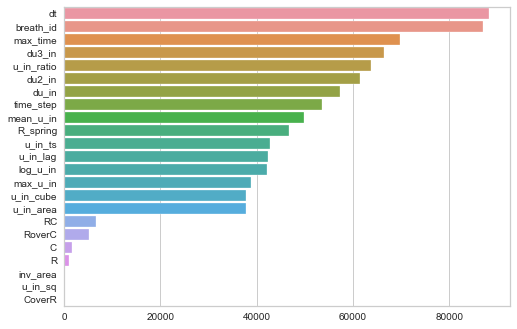

In [71]:
model_lgbm.feature_importances_
indices = np.argsort(model_lgbm.feature_importances_)[::-1]
g = sns.barplot(y=X_train.columns[indices],x = model_lgbm.feature_importances_[indices] , orient='h')

In [72]:
# doesn't work...just with catboost?
# from yellowbrick.model_selection import ValidationCurve

# fig,ax = plt.subplots(figsize=(10,6))
# vc_viz = ValidationCurve(
#                         CatBoostRegressor(),
#                         param_name='iterations',
#                         param_range=np.arange(500,20000,2000),
#                         cv=5,
#                         n_jobs=-1,
#                         )
# vc_viz.fit(X,y)
# vc_viz.poof()

In [ ]:
# from sklearn.ensemble import BaggingClassifier

# bag_clf = 

In [125]:
# grid search - this one works, yes?
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

#instantiate the model
model_cbcv = CatBoostRegressor(verbose=False, task_type='GPU')
model_lgbm = LGBMRegressor()
#create the grid
grid = {'max_depth': [9,10,11],'n_estimators':[1000, 2000, 4000]}
# instantiate gridsearchcv
gscv = GridSearchCV (estimator = model_cbcv, param_grid = grid, scoring ="neg_mean_absolute_error", cv = 5)
gscv.fit(train_in,y_in)

#print(gscv.best_estimator_)
#print(gscv.best_score_)
print(f'best params: {gscv.best_params_}, score = {gscv.best_score_}')

# best score shows -.7165, but lb shows .79xx
#{'max_depth': 8, 'n_estimators': 2000}: -0.8436575768171275  (6,7,8 dpth, 500,100,2000 iter)
#{'max_depth': 11, 'n_estimators': 4000}: -0.7858067935438783

-0.7858067935438783
{'max_depth': 11, 'n_estimators': 4000}


In [88]:
# gscv.cv_results_

# 303514

303514

In [89]:
# try again later
# import numpy as np
# from sklearn.model_selection import GroupKFold
# #X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
# #y = np.array([1, 2, 3, 4])
# #groups = np.array([0, 0, 2, 2])
# groups = train_in['breath_id']
# group_kfold = GroupKFold(n_splits=5)
# group_kfold.get_n_splits(train_in, y_in, groups)

# print(group_kfold)

# for train_index, valid_index in group_kfold.split(train_in, y_in, groups):
#     print("Train", train_index, "Valid:", valid_index)
#     X_train, X_valid = train_in[train_index], train_in[Valid_index]
#     y_train, y_valid = y_in[train_index], y_in[valid_index]
#     print(X_train, X_valid, y_train, y_valid)

GroupKFold(n_splits=5)
Train [     0      1      2 ... 303511 303512 303513] Valid: [    91     92     93 ... 303391 303392 303393]


KeyError: "None of [Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,\n                 8,      9,\n            ...\n            303504, 303505, 303506, 303507, 303508, 303509, 303510, 303511,\n            303512, 303513],\n           dtype='int64', length=242811)] are in the [columns]"

In [81]:
# RFC Parameters tunning 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
kfold = StratifiedKFold(n_splits=5)

model_rf = RandomForestRegressor()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(model_rf,param_grid = rf_param_grid, scoring="accuracy", n_jobs= -1, verbose = 1) # removed cv

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

pred_rf = model_rf.predict(X_valid)
rf_mae = mean_absolute_error(pred_rf,y_valid)

# Best score
#gsRFC.best_score_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    9.4s finished


KeyError: 'gini'

In [ ]:
# from sklearn.linear_model import LinearRegression

# model_lr = LGBMRegressor()
# model_lr.fit(X_train,y_train)
# pred_lr = model_lr.predict(X_valid)
# score_lr = mean_absolute_error(y_valid,pred_lr)
# print(f'LR MAE Score, i = {0}: {score_lr}')
# score = 1.223

In [ ]:
# from sklearn.preprocessing import PolynomialFeatures

# poly_reg=PolynomialFeatures(degree=2)

# X_train_poly=poly_reg.fit_transform(X_train)
# poly_reg.fit(X_train_poly,y_train)

# lin_reg2=LinearRegression()
# lin_reg2.fit(X_train_poly,y_train)
# pred_lr2 = lin_reg2.predict(X_valid)
# score_lr = mean_absolute_error(y_valid,pred_lr2)
# print(f'LR MAE Score, i = {0}: {score_lr}')

In [ ]:
# pred_cv_final = gscv.predict(test_in)

In [73]:
%%time
#random forest - trying to convert to catboost
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_valid)
rf_mae = mean_absolute_error(pred_rf,y_valid)
print(f'Random Forest MAE Score: {rf_mae}')

# (n_estimators=100, max_depth=7,min_samples_leaf=0.06, random_state=12), mae=3.12775, lb score = 6.431(?)
# Why is random forest worse?  
# 10/17/21: Still worse after using only inhales
# defaults: runs out of memory!!!???
#   - because random forests take a ton of memory.
# (n_estimators=100, max_depth=7,min_samples_leaf=0.06, random_state=12) = 5.867
# reduced dtype sizes on ints: 
# 3.627 default, lb = 3.710
# changed criterion to mae...doesn't work...removed

# with dt and du_in, shift=1, 2.364 vs. lb of 2.37.  Beats catboost (400,.6)
# with dt and du_in, shift=2, Random Forest MAE Score: 2.058162936194095
# with dt and du_in, shift=3, Random Forest MAE Score: 2.03014981349922
# interesting shift 3 is a little better.

# deriv and integral, shift=1, .7934!!!
# but leaderboard was .8897
# try shift = 2, = .934 (a little lower)
# added max_time column, down to .6429!  
# added d_area column - actually increased a little to .64394, but possible that lb is better...maybe try it.
# added max_u_in (in addition to max_time), .55379
# with ratio 1/R*area increase a little: .53347, lb score improved a bit to .61
# with RC, etc... .53109, .61 lb .6105 vs .6144ish
# with 3rd derivative and u_in squared:  .50277 vs. .5846 lb...best so far
# with more features, and lower cb score: 0.522197 (worse).  Still, check lb.
# withu_in_mean: .4449!!!, try lb: .5586 up from .58xx but was hoping for more.  Try lightgbm
# with 10000 breath sampling: .573

Random Forest MAE Score: 0.5736288982988603
Wall time: 6min 3s


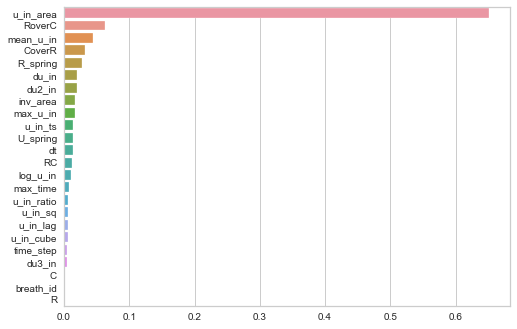

In [74]:
model_rf.feature_importances_
indices = np.argsort(model_rf.feature_importances_)[::-1]
g = sns.barplot(y=X_train.columns[indices],x = model_rf.feature_importances_[indices] , orient='h')

In [ ]:
X_test_in.shape

In [ ]:
X_train.shape

# Final Model Submission

In [36]:
#try summing the two predictions (both at 10%)
pred_f1 = model_cat.predict(X_test_in)
pred_f2 = model_lgbm.predict(X_test_in)
pred_f1
# not great, lb = ~.82xx vs .58xx best so far

array([ 6.40323111,  6.3771402 ,  7.51062143, ..., 10.39902541,
       10.58561783, 10.855282  ])

In [38]:
pred_final = (pred_f1 + pred_f2)/2
pred_final

array([ 6.64953954,  6.64073423,  7.54051464, ..., 10.34284044,
       10.55418696, 10.71420903])

In [ ]:
pred_final = model_cat.predict(X_test_in)
# add indexs to recombine with out preds
pred_final_s = pd.Series(pred_final,index=list(test_in.id))
pred_final_s.head()

In [39]:
# add indexs to recombine with out preds
pred_final_s = pd.Series(pred_final,index=list(test_in.id))
pred_final_s.head()

1    6.649540
2    6.640734
3    7.540515
4    8.222166
5    9.656777
dtype: float64

In [40]:
# create outpreds = just ones
out_preds = np.ones(len(test_out))
i = list(test_out.id)
out_preds_s = pd.Series(out_preds,index = i)
out_preds_s

32         1.0
33         1.0
34         1.0
35         1.0
36         1.0
          ... 
4023996    1.0
4023997    1.0
4023998    1.0
4023999    1.0
4024000    1.0
Length: 2496435, dtype: float64

In [41]:
both = pred_final_s.append(out_preds_s).sort_index()
both.values

array([6.64953954, 6.64073423, 7.54051464, ..., 1.        , 1.        ,
       1.        ])

In [42]:
output = pd.DataFrame({'id': test.id, 'pressure': both.values})
output.to_csv('submission.csv', index=False)
print("Submission saved!")

Submission saved!


## Post Analyze prediction vs. actuals and look for trends

In [ ]:
# function to get single breath (id must exist...there are some that are missing)
# also once removed u_out=1, lengths are not always 30 (some 28, etc)
def get_breath(df,my_id):
    return df[df.breath_id == my_id] 

In [ ]:
# %%time
# ### predictions vs. validation data
pred_all = model_lgbm.predict(train_in)

In [ ]:
y_in.values

In [ ]:
#Create a dataframe with breath_id's to make plotting easier
post_analysis = pd.DataFrame({'breath_id': train_in.breath_id, 'prediction': pred_all, 'acutal': y_in.values})
post_analysis['residual'] = pred_all - y_in.values
post_analysis['R'] = train_in.R
post_analysis['C'] = train_in.C
post_analysis['u_in_lag'] = train_in.u_in_lag


In [ ]:
post_analysis.head()

In [ ]:
# make this a function
breath_idx = train_in.breath_id.unique()
fig, ax = plt.subplots(6, 4, figsize=(25,30))
ax = ax.flatten()
for i in range(24):
    b_id = get_breath(post_analysis,breath_idx[i])
    r = b_id.R.iloc[0]
    c = b_id.C.iloc[0]
    ax[i].plot(b_id.prediction,label='prediction')
    ax[i].plot(b_id.acutal,label='actual')
    ax[i].set_title(f'RR Prediction and Actual: Shift=1, Breath id={i}, R={r}, C={c}')
    ax[i].legend();
    
# plt.savefig('v6_shift=1_rf.png')
